In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import pickle
import re

import pandas as pd
import pinecone
import requests
import xmltodict
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from langchain import OpenAI
from langchain.chains import (RetrievalQAWithSourcesChain,
                              VectorDBQAWithSourcesChain)
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers import ChatGPTPluginRetriever
from langchain.text_splitter import (CharacterTextSplitter,
                                     RecursiveCharacterTextSplitter)
from langchain.vectorstores import FAISS, Pinecone

/Users/eugene/projects/gpt-dev/.venv/lib/python3.9/site-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import sys

sys.path.append('..')

from logger import logger
from config import PINECONE_ENV

In [4]:
load_dotenv()

True

## Initilize retriever

In [4]:
# retriever = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

## Load dataframes

In [54]:
df_path_list = ['../data/charitymajors.parquet', '../data/naval.parquet', '../data/paulgraham.parquet',
           '../data/pmarca.parquet', '../data/willlarson.parquet']

In [55]:
df_list = []

for df_path in df_path_list:
    df = pd.read_parquet(df_path)
    df_list.append(df)

In [56]:
df = pd.concat(df_list)

## Spilt text into documents

In [57]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=50)

docs, metadata = [], []

for i, page in df.iterrows():
    splits = text_splitter.split_text(page['text'])
    # for split in splits:
    #     docs.append(split)
    #     metadata.append({'source': split, 'url': page['url']})
    docs.extend(splits)
    metadata.extend([{'source': page['url']}] * len(splits))  # This Q&A chain relies on the url being in the 'source' key
    logger.info(f'Split {page["url"]} into {len(splits)} docs')

2023-03-27 19:26:36,083 - Split https://charity.wtf/2015/12/27/hello-world/ into 1 docs
2023-03-27 19:26:36,084 - Split https://charity.wtf/2015/12/29/2015-what-happened/ into 4 docs
2023-03-27 19:26:36,085 - Split https://charity.wtf/2016/02/03/how-to-survive-an-acquisition/ into 3 docs
2023-03-27 19:26:36,086 - Split https://charity.wtf/2016/02/23/two-weeks-with-terraform/ into 8 docs
2023-03-27 19:26:36,087 - Split https://charity.wtf/2016/03/23/aws-networking-environments-and-you/ into 12 docs
2023-03-27 19:26:36,088 - Split https://charity.wtf/2016/03/30/terraform-vpc-and-why-you-want-a-tfstate-file-per-env/ into 14 docs
2023-03-27 19:26:36,089 - Split https://charity.wtf/2016/04/04/nail-polish-the-superior-paint/ into 3 docs
2023-03-27 19:26:36,089 - Split https://charity.wtf/2021/08/21/why-every-software-engineering-interview-should-include-ops-questions/ into 5 docs
2023-03-27 19:26:36,090 - Split https://charity.wtf/2016/04/14/scrapbag-of-useful-terraform-tips/ into 8 docs
202

In [58]:
docs[-5:]

['very intentionally) following this rule: get great people, worry about steering the boat later. When I first read Graham’s statement about being certain about being able to find a money making idea if he had the right founders, I was pretty hesitant. Indeed, I found the statement to come off as slightly arrogant. After reading more of his works, and of a number of other books and articles (and also monitoring the success of the Y-Combinator companies), it seems more and more that what he said is true: with the right people, the boat may as well steer itself.Alright, now weave Ayn Rand into this web for usIf we look at the heroes in Ayn Rand’s novels, they are all extremely competent, driven by a need to conform to incredibly high standards, and exceptionally selfless (and they are all men, because Ayn Rand believed women existed to worship men, which is pointedly not</strong/> an argument ever made by either Paul Graham or Jim Collins; on a slightly</em/> different note the Passions 

In [59]:
metadata[-5:]

[{'source': 'https://lethain.com/good-to-great-paul-graham-and-ayn-rand-repost/'},
 {'source': 'https://lethain.com/good-to-great-paul-graham-and-ayn-rand-repost/'},
 {'source': 'https://lethain.com/reflections-on-django-repost/'},
 {'source': 'https://lethain.com/finding-our-programming-flow-repost/'},
 {'source': 'https://lethain.com/finding-our-programming-flow-repost/'}]

## Set up pinecone index

In [28]:
pinecone.init(api_key=os.getenv('PINECONE_API_KEY_BOARD'), environment=PINECONE_ENV)

In [30]:
# Create index
index_name = 'board'
index = pinecone.Index(index_name)

# Delete and recreate index
# pinecone.delete_index(index_name)
pinecone.create_index(index_name, dimension=1536, metric='cosine', pod_type='p2.x1')
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [60]:
embeddings = OpenAIEmbeddings()

# Load existing pinecone index
store = Pinecone.from_existing_index(index_name=index_name, embedding=embeddings)
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [61]:
# Add data to pinecone in chunks to avoid errors
chunk_size = 100
last_chunk = 0
num_chunks = math.ceil(len(docs) / chunk_size)

for i in range(last_chunk, num_chunks):    
    start_idx = i * chunk_size 
    end_idx = min(start_idx + chunk_size, len(docs))
    logger.info(f'Adding chunk {i+1} of {num_chunks} ({start_idx} to {end_idx}))')
    
    _docs = docs[start_idx:end_idx]
    _metadata = metadata[start_idx:end_idx]
    
    store.add_texts(_docs, _metadata)

2023-03-27 19:28:04,350 - Adding chunk 1 of 68 (0 to 100))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:28:26,108 - Adding chunk 2 of 68 (100 to 200))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:28:47,099 - Adding chunk 3 of 68 (200 to 300))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:29:05,352 - Adding chunk 4 of 68 (300 to 400))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:29:25,025 - Adding chunk 5 of 68 (400 to 500))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:29:51,340 - Adding chunk 6 of 68 (500 to 600))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:30:12,532 - Adding chunk 7 of 68 (600 to 700))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:30:32,798 - Adding chunk 8 of 68 (700 to 800))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:30:53,174 - Adding chunk 9 of 68 (800 to 900))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:31:14,863 - Adding chunk 10 of 68 (900 to 1000))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:31:36,183 - Adding chunk 11 of 68 (1000 to 1100))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:31:59,638 - Adding chunk 12 of 68 (1100 to 1200))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:32:17,816 - Adding chunk 13 of 68 (1200 to 1300))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:32:38,598 - Adding chunk 14 of 68 (1300 to 1400))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:33:03,783 - Adding chunk 15 of 68 (1400 to 1500))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:33:23,166 - Adding chunk 16 of 68 (1500 to 1600))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:33:46,006 - Adding chunk 17 of 68 (1600 to 1700))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:34:10,143 - Adding chunk 18 of 68 (1700 to 1800))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:34:30,456 - Adding chunk 19 of 68 (1800 to 1900))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:34:52,963 - Adding chunk 20 of 68 (1900 to 2000))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:35:12,425 - Adding chunk 21 of 68 (2000 to 2100))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:35:34,361 - Adding chunk 22 of 68 (2100 to 2200))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:35:56,774 - Adding chunk 23 of 68 (2200 to 2300))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:36:18,752 - Adding chunk 24 of 68 (2300 to 2400))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:36:37,064 - Adding chunk 25 of 68 (2400 to 2500))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:36:55,902 - Adding chunk 26 of 68 (2500 to 2600))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:37:19,313 - Adding chunk 27 of 68 (2600 to 2700))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:37:39,599 - Adding chunk 28 of 68 (2700 to 2800))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:38:01,710 - Adding chunk 29 of 68 (2800 to 2900))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:38:23,253 - Adding chunk 30 of 68 (2900 to 3000))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:38:44,271 - Adding chunk 31 of 68 (3000 to 3100))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:39:04,420 - Adding chunk 32 of 68 (3100 to 3200))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:39:27,833 - Adding chunk 33 of 68 (3200 to 3300))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:39:49,067 - Adding chunk 34 of 68 (3300 to 3400))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:40:11,127 - Adding chunk 35 of 68 (3400 to 3500))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:40:30,514 - Adding chunk 36 of 68 (3500 to 3600))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:40:52,738 - Adding chunk 37 of 68 (3600 to 3700))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:41:14,464 - Adding chunk 38 of 68 (3700 to 3800))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:41:33,724 - Adding chunk 39 of 68 (3800 to 3900))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:41:57,728 - Adding chunk 40 of 68 (3900 to 4000))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:42:17,554 - Adding chunk 41 of 68 (4000 to 4100))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:42:38,107 - Adding chunk 42 of 68 (4100 to 4200))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:43:00,277 - Adding chunk 43 of 68 (4200 to 4300))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:43:24,237 - Adding chunk 44 of 68 (4300 to 4400))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:43:46,561 - Adding chunk 45 of 68 (4400 to 4500))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:44:08,135 - Adding chunk 46 of 68 (4500 to 4600))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:44:29,443 - Adding chunk 47 of 68 (4600 to 4700))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:44:49,157 - Adding chunk 48 of 68 (4700 to 4800))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:45:12,227 - Adding chunk 49 of 68 (4800 to 4900))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:45:32,907 - Adding chunk 50 of 68 (4900 to 5000))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:45:53,030 - Adding chunk 51 of 68 (5000 to 5100))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:46:10,351 - Adding chunk 52 of 68 (5100 to 5200))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:46:29,276 - Adding chunk 53 of 68 (5200 to 5300))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:46:50,227 - Adding chunk 54 of 68 (5300 to 5400))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:47:10,697 - Adding chunk 55 of 68 (5400 to 5500))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:47:31,538 - Adding chunk 56 of 68 (5500 to 5600))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:47:52,160 - Adding chunk 57 of 68 (5600 to 5700))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:48:10,036 - Adding chunk 58 of 68 (5700 to 5800))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:48:30,796 - Adding chunk 59 of 68 (5800 to 5900))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:48:50,347 - Adding chunk 60 of 68 (5900 to 6000))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:49:12,652 - Adding chunk 61 of 68 (6000 to 6100))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:49:33,207 - Adding chunk 62 of 68 (6100 to 6200))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:49:53,910 - Adding chunk 63 of 68 (6200 to 6300))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:50:17,314 - Adding chunk 64 of 68 (6300 to 6400))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:50:37,123 - Adding chunk 65 of 68 (6400 to 6500))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:50:54,341 - Adding chunk 66 of 68 (6500 to 6600))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:51:16,386 - Adding chunk 67 of 68 (6600 to 6700))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-03-27 19:51:36,034 - Adding chunk 68 of 68 (6700 to 6760))


Upserted vectors:   0%|          | 0/60 [00:00<?, ?it/s]

## Load data from eugeneyan.com

In [7]:
df = pd.read_parquet('../data/eugeneyan.parquet')

In [19]:
splits = text_splitter.split_text(df[df['url'] == 'https://eugeneyan.com/writing/bandits/']['text'])

In [24]:
print(splits[-2])

During evaluation, replay takes in the new policy (to be evaluated) and the logged policy events. If the new policy chooses the same action as the logged policy, the event is added to the history and the reward is updated. If not, the event is ignored with no reward update. (Counterfactual evaluation via Inverse Propensity Scoring is another alternative.)
How does bandit off-policy evaluation compare to typical supervised machine learning evaluation on logged data? Twitter’s paper provides some insight. They computed two sets of metrics: (i) PR-AUC on a standard test set and (ii) CTR improvements vs. a random policy. There was a trade-off between PR-AUC and CTR.
Although the greedy policy performed well on PR-AUC, it did relatively poorly on CTR. Conversely, bandit policies such as UCB and Thompson Sampling did poorer on PR-AUC but outperformed the greedy policy on CTR. This shows the divergence where supervised learning that evaluates well on biased logged data via conventional metric

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=50)

docs, metadata = [], []

for i, page in df.iterrows():
    splits = text_splitter.split_text(page['text'])
    # for split in splits:
    #     docs.append(split)
    #     metadata.append({'source': split, 'url': page['url']})
    docs.extend(splits)
    metadata.extend([{'source': page['url']}] * len(splits))  # This Q&A chain relies on the url being in the 'source' key
    logger.info(f'Split {page["url"]} into {len(splits)} docs')

2023-04-01 17:36:27,662 - Split https://eugeneyan.com/writing/llm-bio/ into 9 docs
2023-04-01 17:36:27,663 - Split https://eugeneyan.com/writing/labeling-guidelines/ into 5 docs
2023-04-01 17:36:27,664 - Split https://eugeneyan.com/writing/content-moderation/ into 14 docs
2023-04-01 17:36:27,665 - Split https://eugeneyan.com/writing/mechanisms-for-teams/ into 6 docs
2023-04-01 17:36:27,666 - Split https://eugeneyan.com/writing/mechanisms-for-projects/ into 5 docs
2023-04-01 17:36:27,668 - Split https://eugeneyan.com/writing/roam-to-obsidian/ into 2 docs
2023-04-01 17:36:27,669 - Split https://eugeneyan.com/writing/getting-help/ into 3 docs
2023-04-01 17:36:27,671 - Split https://eugeneyan.com/writing/2022-in-review/ into 6 docs
2023-04-01 17:36:27,673 - Split https://eugeneyan.com/writing/autoencoders-vs-diffusers/ into 3 docs
2023-04-01 17:36:27,675 - Split https://eugeneyan.com/writing/text-to-image/ into 15 docs
2023-04-01 17:36:27,676 - Split https://eugeneyan.com/writing/recsys202

In [11]:
pinecone.init(api_key=os.getenv('PINECONE_API_KEY_EY'), environment=PINECONE_ENV)

In [12]:
# Create index
index_name = 'ask-ey'
index = pinecone.Index(index_name)

# Delete and recreate index
pinecone.delete_index(index_name)
pinecone.create_index(index_name, dimension=1536, metric='cosine', pod_type='p2.x1')
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [14]:
embeddings = OpenAIEmbeddings()

# Load existing pinecone index
store = Pinecone.from_existing_index(index_name=index_name, embedding=embeddings)
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [15]:
# Add data to pinecone in chunks to avoid errors
chunk_size = 100
last_chunk = 0
num_chunks = math.ceil(len(docs) / chunk_size)

for i in range(last_chunk, num_chunks):    
    start_idx = i * chunk_size 
    end_idx = min(start_idx + chunk_size, len(docs))
    logger.info(f'Adding chunk {i+1} of {num_chunks} ({start_idx} to {end_idx}))')
    
    _docs = docs[start_idx:end_idx]
    _metadata = metadata[start_idx:end_idx]
    
    store.add_texts(_docs, _metadata)

2023-04-01 17:39:04,282 - Adding chunk 1 of 10 (0 to 100))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:39:24,059 - Adding chunk 2 of 10 (100 to 200))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:39:41,680 - Adding chunk 3 of 10 (200 to 300))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:39:59,806 - Adding chunk 4 of 10 (300 to 400))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:40:18,058 - Adding chunk 5 of 10 (400 to 500))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:40:37,073 - Adding chunk 6 of 10 (500 to 600))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:40:56,440 - Adding chunk 7 of 10 (600 to 700))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:41:14,563 - Adding chunk 8 of 10 (700 to 800))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:41:34,757 - Adding chunk 9 of 10 (800 to 900))


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

2023-04-01 17:41:53,633 - Adding chunk 10 of 10 (900 to 978))


Upserted vectors:   0%|          | 0/78 [00:00<?, ?it/s]

## Check embeddings

In [33]:
embedding_enc = OpenAIEmbeddings()

In [69]:
a = 'How do I decide between being a manager or an IC?'
a2 = 'manager or IC'
b = 'How do I decide between being a manager or an engineer?'
b2 = 'manager or engineer'
c = 'manager'
c2 = 'IC'
c3 = 'engineer'
d = 'manager engineer pendulum'
d2 = 'manager IC pendulum'

x = 'What bandits are used in recommendation systems?'
x2 = 'What types of bandits are used in recommendation systems?'
x3 = 'What types of bandit algorithms are used in recommendation systems?'
y = 'How are bandits are used in recommendation systems?'
y2 = 'How are bandit algorithtms are used in recommendation systems?'
z = 'bandits used in recommendation systems'
z2 = 'bandits in recommendation systems'
z3 = 'bandit recommendation systems'

query_list = [a, a2, b, b2, c, c2, c3, d, d2, x, x2, x3, y, y2, z, z2, z3]

In [111]:
query_emb_list = []

for query in query_list:
    query_emb_list.append((query, embedding_enc.embed_query(query)))

In [250]:
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

In [46]:
embeddings = np.vstack(embedding_list)

In [47]:
embeddings.shape

(17, 1536)

In [55]:
tsne = TSNE(n_components=2, random_state=0, perplexity=16, n_iter=5000, verbose=1)
embeddings_2d = tsne.fit_transform(embeddings)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 17 samples in 0.001s...
[t-SNE] Computed neighbors for 17 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 17 / 17
[t-SNE] Mean sigma: 7.032393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.065853
[t-SNE] KL divergence after 850 iterations: 0.365748


In [56]:
embeddings_2d

array([[ 26.933899  ,  -8.558991  ],
       [ 48.42427   ,   0.08291823],
       [ 39.206135  , -28.578968  ],
       [-10.841957  , -18.65667   ],
       [ 16.94178   ,  37.734627  ],
       [  5.1673136 ,  -2.7281857 ],
       [-16.428877  ,   2.5202003 ],
       [ 11.026998  , -24.613327  ],
       [-39.66949   ,   0.18514854],
       [ 17.531504  , -46.53371   ],
       [ 40.259254  ,  25.520218  ],
       [ 20.806347  ,  12.865766  ],
       [-27.909395  ,  24.114546  ],
       [ -1.1609986 ,  19.0791    ],
       [ -8.830331  ,  41.533566  ],
       [-10.081632  , -42.452076  ],
       [-33.088768  , -25.175682  ]], dtype=float32)

## Get pinecone embeddings

In [74]:
pinecone.init(api_key=os.getenv('PINECONE_API_KEY_EY'), environment=PINECONE_ENV)
index_name = 'ask-ey'
index = pinecone.Index(index_name)

In [75]:
store = Pinecone.from_existing_index(index_name=index_name, embedding=embedding_enc).as_retriever()

In [311]:
store.get_relevant_documents('What bandits are used in recommendation systems?')

[Document(page_content='Do you know of other industrial implementations of bandit-based recommendation systems? Please share them in the comments below!', lookup_str='', metadata={'source': 'https://eugeneyan.com/writing/bandits/'}, lookup_index=0),
 Document(page_content='Do you know of other industrial implementations of bandit-based recommendation systems? Please share them in the comments below!', lookup_str='', metadata={'source': 'https://eugeneyan.com/writing/bandits/'}, lookup_index=0),
 Document(page_content='That was a whirlwind tour of the various patterns for personalization in recommendations and search. These patterns are not exhaustive. I’ve also come across papers that add multi-interest heads and learn interest hierarchies on top of user interests, as well as approaches to model user interest across domains. When to use which? Here’s a rough heuristic:\nIf you’re starting with personalization, good ol’ logistic regression with crossed features is a tough baseline to be

In [309]:
store.get_relevant_documents('How are bandits used in recommendation systems?')

[Document(page_content='Do you know of other industrial implementations of bandit-based recommendation systems? Please share them in the comments below!', lookup_str='', metadata={'source': 'https://eugeneyan.com/writing/bandits/'}, lookup_index=0),
 Document(page_content='That was a whirlwind tour of the various patterns for personalization in recommendations and search. These patterns are not exhaustive. I’ve also come across papers that add multi-interest heads and learn interest hierarchies on top of user interests, as well as approaches to model user interest across domains. When to use which? Here’s a rough heuristic:\nIf you’re starting with personalization, good ol’ logistic regression with crossed features is a tough baseline to beat. If you’re building a real-time recommender (i.e., generates recs on request), learning item embeddings via word2vec and applying approximate nearest neighbors is pretty lean and gets much of the juice from session-level behavioral data.\nDid I mi

In [91]:
doc_dict = {}

for query in query_list:
    logger.info(f'Embedding query: {query}')
    results = store.get_relevant_documents(query)
    doc_dict[query] = results

2023-04-03 09:35:45,231 - Embedding query: How do I decide between being a manager or an IC?
2023-04-03 09:35:46,135 - Embedding query: manager or IC
2023-04-03 09:35:46,799 - Embedding query: How do I decide between being a manager or an engineer?
2023-04-03 09:35:47,303 - Embedding query: manager or engineer
2023-04-03 09:35:47,518 - Embedding query: manager
2023-04-03 09:35:48,015 - Embedding query: IC
2023-04-03 09:35:48,561 - Embedding query: engineer
2023-04-03 09:35:48,768 - Embedding query: manager engineer pendulum
2023-04-03 09:35:49,703 - Embedding query: manager IC pendulum
2023-04-03 09:35:50,302 - Embedding query: What bandits are used in recommendation systems?
2023-04-03 09:35:51,205 - Embedding query: What types of bandits are used in recommendation systems?
2023-04-03 09:35:51,407 - Embedding query: What types of bandit algorithms are used in recommendation systems?
2023-04-03 09:35:52,322 - Embedding query: How are bandits are used in recommendation systems?
2023-04-

In [101]:
content_list = []
source_list = []

for query in query_list:
    for doc in doc_dict[query]:
        content = doc.page_content
        url = doc.metadata['source']
        logger.info(f'Content: {content} | URL: {url}')
        emb = embedding_enc.embed_query(content)
        content_list.append((content, emb))
        source_list.append((url, emb))

2023-04-03 09:40:56,880 - Content: I also get a lot of questions on LinkedIn, Twitter, email, Quora. I try to answer these questions, but it doesn’t scale. That was another reason I started the community slack. People can ask these questions in public, and we can answer them. Maybe if I start by showing an example, more people can help with the questions?
The community also hosts meetups. One reason why I do this, is sometimes I want to talk at a conference, I submit a great proposal, and I’m rejected (laughs).
It’s disappointing, and I think, why do I have to submit a proposal? Why do I need a conference? Can’t I just talk about it myself? And this is how it happened, maybe I can just host meetups.
Also, a friend asked, do you know of a place where I can give a talk? Why yes I do! This was the SageMaker event that you attended. It was our first talk.
Eugene: Currently, Alexey hosts one talk a week. I don’t know how he keeps up with the cadence, but it’s a great time to join datatalks.

In [220]:
content_df = pd.DataFrame(content_list, columns=['_content', 'embedding'])
source_df = pd.DataFrame(source_list, columns=['_content', 'embedding'])
query_df = pd.DataFrame(query_emb_list, columns=['_content', 'embedding'])

In [253]:
content_df['content'] = 'Doc: ' + content_df['_content'].apply(lambda x: x[:50])
source_df['content'] = 'URL: ' + source_df['_content'].apply(lambda x: x[:50])
query_df['content'] = 'Query: ' + query_df['_content']

In [254]:
df = pd.concat((content_df, query_df))
df.shape

(102, 3)

In [255]:
df = df.drop_duplicates(subset=['content'])
df.shape

(35, 3)

In [256]:
embeddings = np.vstack(df['embedding'])

In [257]:
embeddings.shape

(35, 1536)

In [258]:
tsne = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=10000, verbose=1, metric='cosine')
embeddings_2d = tsne.fit_transform(embeddings)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 35 samples in 0.001s...
[t-SNE] Computed neighbors for 35 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 35 / 35
[t-SNE] Mean sigma: 0.054875
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.278831
[t-SNE] KL divergence after 1200 iterations: 0.255677


In [259]:
embeddings_2d.shape

(35, 2)

In [260]:
df.shape

(35, 3)

In [261]:
df = df.reset_index(drop=True)

In [262]:
def apply_colour(x):
    if x.startswith('Doc'):
        return 'blue'
    elif x.startswith('URL'):
        return 'green'
    else:
        return 'red'
    
def apply_label(x):
    if x.startswith('Doc'):
        return 'Doc'
    elif x.startswith('URL'):
        return 'URL'
    else:
        return 'Query'

In [264]:
df['colour'] = df['content'].apply(apply_colour)
df['label'] = df['content'].apply(apply_label)

In [272]:
df['embedding_2d'] = list(embeddings_2d)

In [273]:
df

,_content,embedding,content,colour,label,embedding_2d
0,"I also get a lot of questions on LinkedIn, Twi...","[0.02575155906379223, -0.004037376958876848, 0...",Doc: I also get a lot of questions on LinkedIn...,blue,Doc,"[-25.48357, -8.561122]"
1,This metaphor also helps with other questions....,"[0.012818613089621067, -0.022875864058732986, ...",Doc: This metaphor also helps with other quest...,blue,Doc,"[-22.031265, 32.123123]"
2,Do the due diligence before accepting the job ...,"[-0.0028124817181378603, -0.009836859069764614...",Doc: Do the due diligence before accepting the...,blue,Doc,"[-17.679733, 11.384646]"
3,"You might ask, how do I find time for all thes...","[-0.005430013872683048, -0.022357318550348282,...","Doc: You might ask, how do I find time for all...",blue,Doc,"[-24.587933, 12.85849]"
4,This thinking explains my inclination towards ...,"[-0.0021128200460225344, 0.0053935302421450615...",Doc: This thinking explains my inclination tow...,blue,Doc,"[-7.978435, -11.028734]"
5,"This leads to regulations, such as the EU’s Ge...","[0.0003634189488366246, -0.0107890535145998, 0...","Doc: This leads to regulations, such as the EU...",blue,Doc,"[-3.0503447, 5.836676]"
6,"Non-positive & incremental: Sometimes, we make...","[-0.019932148978114128, -0.002726502250880003,...","Doc: Non-positive & incremental: Sometimes, we...",blue,Doc,"[-2.765868, -8.181991]"
7,And it appears to be a trend specific to the U...,"[0.0023003185633569956, -0.0079970583319664, 0...",Doc: And it appears to be a trend specific to ...,blue,Doc,"[-12.810587, 7.2860155]"
8,"Often, we learn a lot of theory and knowledge ...","[-0.01314166747033596, -0.013879658654332161, ...","Doc: Often, we learn a lot of theory and knowl...",blue,Doc,"[1.9544867, -30.257763]"
9,Spark+AI Summit 2020 was epic. Some great talk...,"[-0.026843123137950897, -0.005708565469831228,...",Doc: Spark+AI Summit 2020 was epic. Some great...,blue,Doc,"[-33.00584, -11.555028]"


In [286]:
np.vstack(df['embedding_2d'])

array([-25.48357  , -22.031265 , -17.679733 , -24.587933 ,  -7.978435 ,
        -3.0503447,  -2.765868 , -12.810587 ,   1.9544867, -33.00584  ,
       -15.953871 ,   5.656399 , -16.054241 , -23.005733 ,   5.6587625,
        38.436462 ,   6.435587 ,  10.159087 , -30.929203 , -32.511898 ,
       -24.361832 , -20.703575 , -23.865612 , -40.736088 , -15.0249605,
       -25.416685 , -31.767612 ,  27.30905  ,  19.997292 ,  16.309408 ,
        27.828157 ,  23.299587 ,  27.155931 ,  33.846516 ,  28.952288 ],
      dtype=float32)

In [288]:
df.head()

,_content,embedding,content,colour,label,embedding_2d
0,"I also get a lot of questions on LinkedIn, Twi...","[0.02575155906379223, -0.004037376958876848, 0...",Doc: I also get a lot of questions on LinkedIn...,blue,Doc,"[-25.48357, -8.561122]"
1,This metaphor also helps with other questions....,"[0.012818613089621067, -0.022875864058732986, ...",Doc: This metaphor also helps with other quest...,blue,Doc,"[-22.031265, 32.123123]"
2,Do the due diligence before accepting the job ...,"[-0.0028124817181378603, -0.009836859069764614...",Doc: Do the due diligence before accepting the...,blue,Doc,"[-17.679733, 11.384646]"
3,"You might ask, how do I find time for all thes...","[-0.005430013872683048, -0.022357318550348282,...","Doc: You might ask, how do I find time for all...",blue,Doc,"[-24.587933, 12.85849]"
4,This thinking explains my inclination towards ...,"[-0.0021128200460225344, 0.0053935302421450615...",Doc: This thinking explains my inclination tow...,blue,Doc,"[-7.978435, -11.028734]"


In [290]:
df

,_content,embedding,content,colour,label,embedding_2d
0,"I also get a lot of questions on LinkedIn, Twi...","[0.02575155906379223, -0.004037376958876848, 0...",Doc: I also get a lot of questions on LinkedIn...,blue,Doc,"[-25.48357, -8.561122]"
1,This metaphor also helps with other questions....,"[0.012818613089621067, -0.022875864058732986, ...",Doc: This metaphor also helps with other quest...,blue,Doc,"[-22.031265, 32.123123]"
2,Do the due diligence before accepting the job ...,"[-0.0028124817181378603, -0.009836859069764614...",Doc: Do the due diligence before accepting the...,blue,Doc,"[-17.679733, 11.384646]"
3,"You might ask, how do I find time for all thes...","[-0.005430013872683048, -0.022357318550348282,...","Doc: You might ask, how do I find time for all...",blue,Doc,"[-24.587933, 12.85849]"
4,This thinking explains my inclination towards ...,"[-0.0021128200460225344, 0.0053935302421450615...",Doc: This thinking explains my inclination tow...,blue,Doc,"[-7.978435, -11.028734]"
5,"This leads to regulations, such as the EU’s Ge...","[0.0003634189488366246, -0.0107890535145998, 0...","Doc: This leads to regulations, such as the EU...",blue,Doc,"[-3.0503447, 5.836676]"
6,"Non-positive & incremental: Sometimes, we make...","[-0.019932148978114128, -0.002726502250880003,...","Doc: Non-positive & incremental: Sometimes, we...",blue,Doc,"[-2.765868, -8.181991]"
7,And it appears to be a trend specific to the U...,"[0.0023003185633569956, -0.0079970583319664, 0...",Doc: And it appears to be a trend specific to ...,blue,Doc,"[-12.810587, 7.2860155]"
8,"Often, we learn a lot of theory and knowledge ...","[-0.01314166747033596, -0.013879658654332161, ...","Doc: Often, we learn a lot of theory and knowl...",blue,Doc,"[1.9544867, -30.257763]"
9,Spark+AI Summit 2020 was epic. Some great talk...,"[-0.026843123137950897, -0.005708565469831228,...",Doc: Spark+AI Summit 2020 was epic. Some great...,blue,Doc,"[-33.00584, -11.555028]"


/var/folders/0p/z0kzk4l961d2qwv389xj0zd00000gn/T/ipykernel_5442/3467535274.py:25: UserWarning: Glyph 128071 (\N{WHITE DOWN POINTING BACKHAND INDEX}) missing from current font.
  plt.savefig('t-sne.png')
/Users/eugene/projects/gpt-dev/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128071 (\N{WHITE DOWN POINTING BACKHAND INDEX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


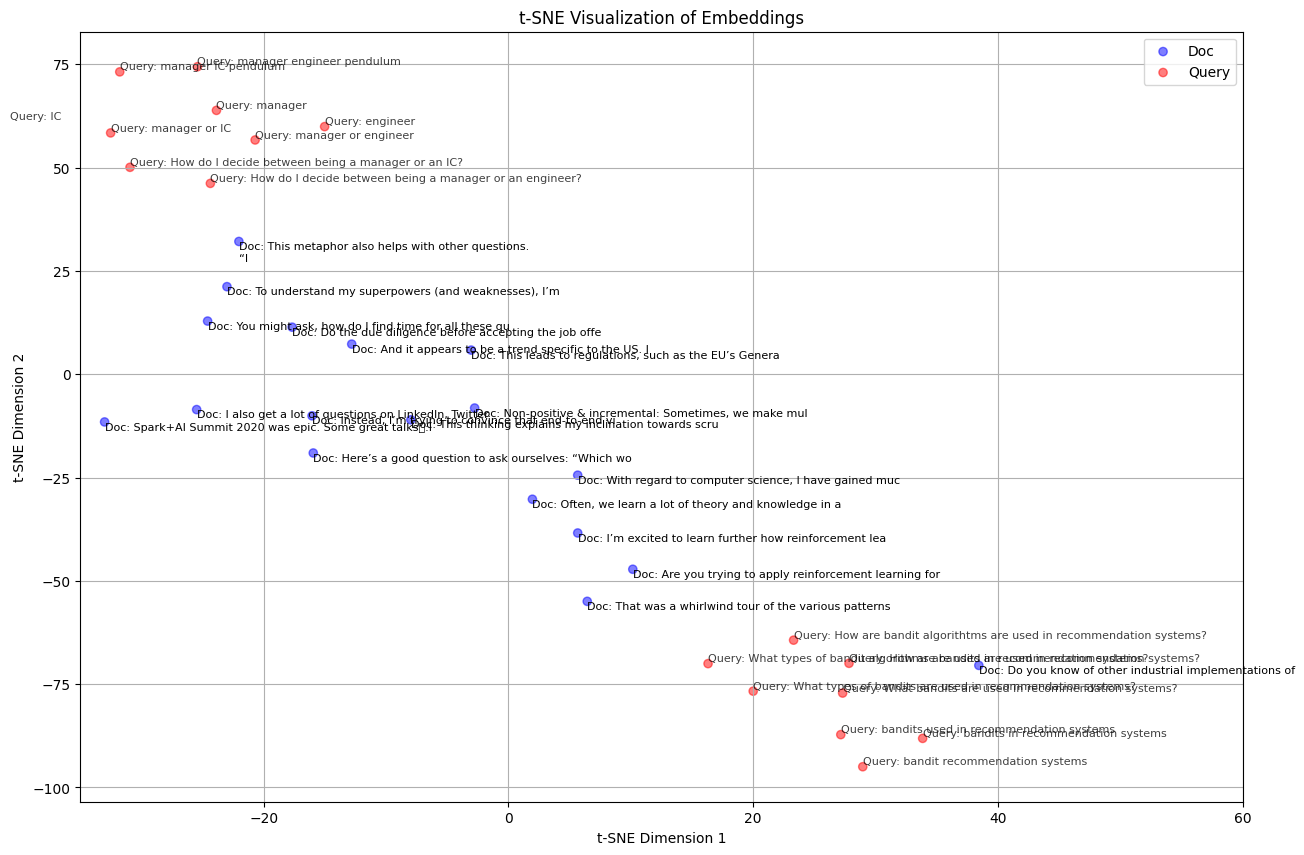

In [302]:
plt.figure(figsize=(15, 10))
plt.grid()

unique_labels = df['label'].unique()
for label in unique_labels:
    subset = df[df['label'] == label]
    embeddings_2d = np.vstack(subset['embedding_2d'])
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=subset['colour'], alpha=0.5, label=label)

_embeddings_2d = np.vstack(df['embedding_2d'])
for i, (x, y) in enumerate(_embeddings_2d):
    content = df.loc[i, 'content']
    label = df.loc[i, 'label']
    if label == 'Query':
        plt.text(x, y, str(content), fontsize=8, ha='left', va='bottom', alpha=0.75)
        
    if label == 'Doc':
        plt.text(x, y, str(content), fontsize=8, ha='left', va='top')

plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.xlim((-35, 60))
plt.savefig('t-sne.png')
plt.show()